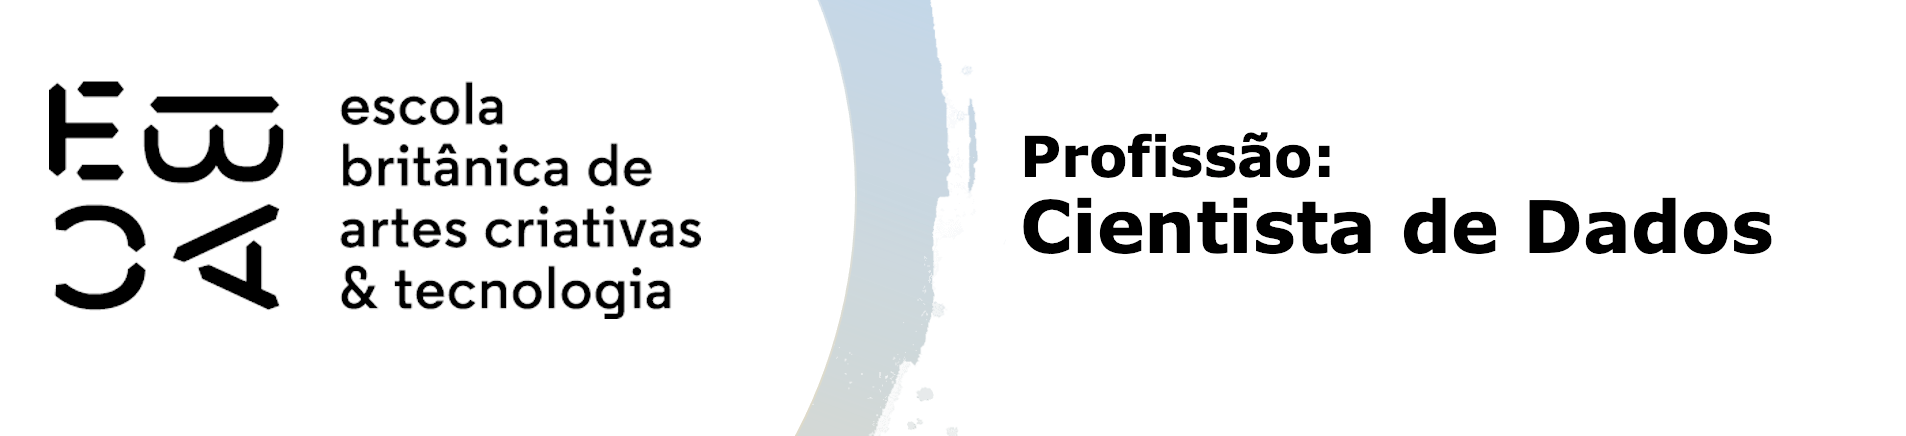

# Modulo 30 Atividade 01
#### João Paulo Costa

## Métodos hierárquicos de agrupamento

## 1) Repetindo o que fizemos em aula

Primeiramente vamos repetir o que fizemos em aula com a base de pinguins.

1. Selecione as variáveis quantitativas da base de pinguins
2. Elimine valores faltantes
3. Padronize as variáveis para média zero e desvio padrão 1
4. Faça um agrupamento hierárquico dividindo essa base em 3 grupos
5. Faça o Dendrograma

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc

In [2]:
sns.set(style="whitegrid", context="notebook")
peng = sns.load_dataset("penguins")

# Seleção de colunas úteis e limpeza de ausentes
cols_num = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
cols_cat = ["species","sex","island"]
df = peng[cols_num + cols_cat].dropna().reset_index(drop=True)

print(f"Linhas após limpeza: {df.shape[0]}")
df.head()

Linhas após limpeza: 333


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species,sex,island
0,39.1,18.7,181.0,3750.0,Adelie,Male,Torgersen
1,39.5,17.4,186.0,3800.0,Adelie,Female,Torgersen
2,40.3,18.0,195.0,3250.0,Adelie,Female,Torgersen
3,36.7,19.3,193.0,3450.0,Adelie,Female,Torgersen
4,39.3,20.6,190.0,3650.0,Adelie,Male,Torgersen


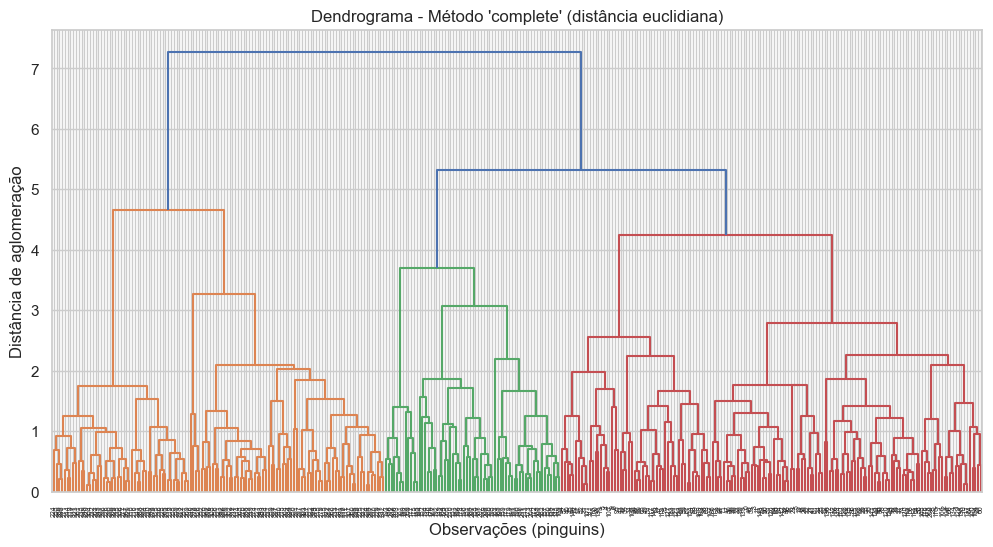

In [3]:
# Padronização e Dendrograma
X = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].copy()
scaler = StandardScaler()
X_pad = scaler.fit_transform(X)  # média 0, desvio 1

plt.figure(figsize=(12, 6))
plt.title("Dendrograma - Método 'complete' (distância euclidiana)")
# linkage: 'complete' costuma separar melhor outliers; 'ward' também é comum (minimiza variância intra-grupo)
dend = shc.dendrogram(shc.linkage(X_pad, method='complete'))
plt.xlabel("Observações (pinguins)")
plt.ylabel("Distância de aglomeração")
plt.show()

## 2) Avalie os grupos

Descreva os grupos:

- Quantos pinguins de cada espécie há em cada grupo?
- Descreva as variáveis quantitativas de cada grupo com as técnicas que você preferir.

In [4]:
# Agrupamento com k=3
k_base = 3
agg = AgglomerativeClustering(n_clusters=k_base, metric='euclidean', linkage='ward')
labels_base = agg.fit_predict(X_pad)

df_base = df.copy()
df_base["cluster"] = labels_base

# Tabelas de contingência
ct_species = pd.crosstab(df_base["cluster"], df_base["species"])
ct_sex_species = pd.crosstab([df_base["cluster"], df_base["sex"]], df_base["species"])

display(ct_species)
display(ct_sex_species)

species,Adelie,Chinstrap,Gentoo
cluster,,,
0,0,0,119
1,146,11,0
2,0,57,0


species         Adelie  Chinstrap  Gentoo
cluster sex                              
0       Female       0          0      58
        Male         0          0      61
1       Female      73         11       0
        Male        73          0       0
2       Female       0         23       0
        Male         0         34       0

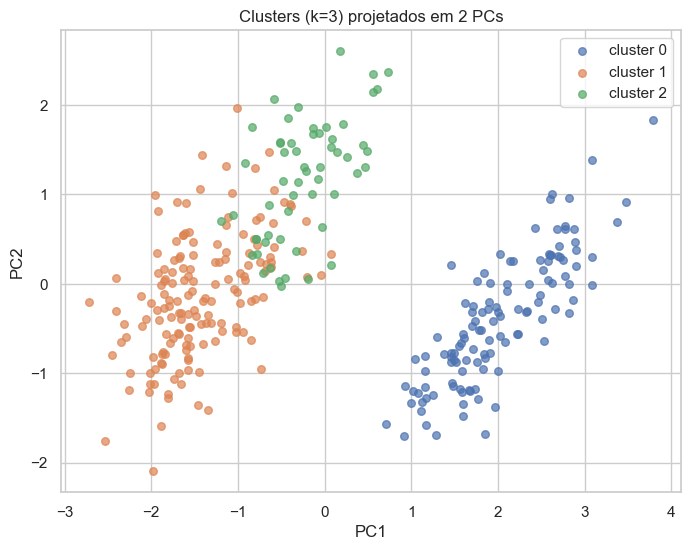

In [5]:
# Visualização 2D via PCA (apenas para plot)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_pad)
viz = pd.DataFrame(coords, columns=["PC1","PC2"])
viz["cluster"] = labels_base
viz["species"] = df["species"].values

plt.figure(figsize=(8,6))
for c in sorted(viz["cluster"].unique()):
    sel = viz["cluster"]==c
    plt.scatter(viz.loc[sel,"PC1"], viz.loc[sel,"PC2"], s=30, alpha=0.7, label=f"cluster {c}")
plt.title("Clusters (k=3) projetados em 2 PCs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [6]:
# Estatísticas resumidas por cluster
stats_base = df_base.groupby("cluster")[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].agg(["mean","std","min","max","median"])
stats_base

bill_length_mm                              bill_depth_mm            \
                  mean       std   min   max median          mean       std   
cluster                                                                       
0            47.568067  3.106116  40.9  59.6   47.4     14.996639  0.985998   
1            39.191720  2.939670  32.1  46.9   39.1     18.286624  1.223755   
2            49.752632  2.710107  45.2  58.0   50.2     18.601754  1.072629   

                           flipper_length_mm                                 \
          min   max median              mean       std    min    max median   
cluster                                                                       
0        13.1  17.3   15.0        217.235294  6.585431  203.0  231.0  216.0   
1        15.5  21.5   18.3        190.038217  6.514171  172.0  210.0  190.0   
2        16.4  20.8   18.7        197.105263  6.526551  181.0  212.0  197.0   

         body_mass_g                                      
                mean         std     min     max  median  
cluster                                                   
0        5092.436975  501.476154  3950.0  6300.0  5050.0  
1        3680.095541  462.120763  2700.0  4775.0  3625.0  
2        3810.087719  338.255096  3250.0  4800.0  3775.0

**Interpretação (k=3):**
- A tabela *cluster × species* permite avaliar se os grupos se alinham com as espécies.
- As estatísticas descritivas mostram diferenças de tamanho de bico, nadadeira e massa entre clusters.
- O gráfico em 2 componentes principais (PCA) ajuda a ver a separação visual dos grupos.

## 3) Alterando o agrupamento

O Dendrogarma sugere que podemem haver grupos interessantes se solicitarmos mais que 3 grupos. Se quisermos testar o agrupamento com mais de 3 grupos, quantos grupos o Dendrograma te sugere? (Dica: não faça mais que 6 grupos).

- Faça o agrupamento hierárquico semelhante ao anterior, mas com o número de grupos que você escolheu.
- Analise esses agrupamentos
    - Quantos pinguins de cada espécie há em cada grupo?
    - Quantos pinguins de cada espécie machos e fêmeas há em cada grupo?
- Na sua opinião, o agrupamento capturou algum padrão natural dos dados? Qual?

In [7]:
# Agrupamento alternativo (k=4)
k_alt = 4
agg_alt = AgglomerativeClustering(n_clusters=k_alt, metric='euclidean', linkage='ward')
labels_alt = agg_alt.fit_predict(X_pad)

df_alt = df.copy()
df_alt["cluster"] = labels_alt

ct_species_alt = pd.crosstab(df_alt["cluster"], df_alt["species"])
ct_sex_species_alt = pd.crosstab([df_alt["cluster"], df_alt["sex"]], df_alt["species"])

display(ct_species_alt)
display(ct_sex_species_alt)

species,Adelie,Chinstrap,Gentoo
cluster,,,
0,146,11,0
1,0,0,70
2,0,57,0
3,0,0,49


species         Adelie  Chinstrap  Gentoo
cluster sex                              
0       Female      73         11       0
        Male        73          0       0
1       Female       0          0       9
        Male         0          0      61
2       Female       0         23       0
        Male         0         34       0
3       Female       0          0      49

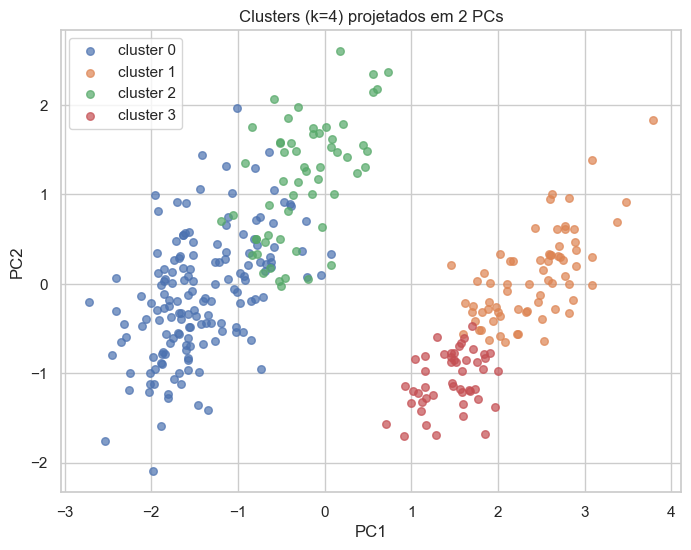

In [8]:
# Visualização PCA
coords_alt = pca.fit_transform(X_pad)
viz_alt = pd.DataFrame(coords_alt, columns=["PC1","PC2"])
viz_alt["cluster"] = labels_alt
viz_alt["species"] = df["species"].values

plt.figure(figsize=(8,6))
for c in sorted(viz_alt["cluster"].unique()):
    sel = viz_alt["cluster"]==c
    plt.scatter(viz_alt.loc[sel,"PC1"], viz_alt.loc[sel,"PC2"], s=30, alpha=0.7, label=f"cluster {c}")
plt.title("Clusters (k=4) projetados em 2 PCs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [9]:
stats_alt = df_alt.groupby("cluster")[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].agg(["mean","std","min","max","median"])
stats_alt

bill_length_mm                              bill_depth_mm            \
                  mean       std   min   max median          mean       std   
cluster                                                                       
0            39.191720  2.939670  32.1  46.9  39.10     18.286624  1.223755   
1            49.260000  2.637983  44.4  59.6  49.25     15.624286  0.738670   
2            49.752632  2.710107  45.2  58.0  50.20     18.601754  1.072629   
3            45.151020  1.891001  40.9  49.1  45.30     14.100000  0.458712   

                           flipper_length_mm                                 \
          min   max median              mean       std    min    max median   
cluster                                                                       
0        15.5  21.5  18.30        190.038217  6.514171  172.0  210.0  190.0   
1        14.1  17.3  15.65        221.042857  5.504769  208.0  231.0  220.5   
2        16.4  20.8  18.70        197.105263  6.526551  181.0  212.0  197.0   
3        13.1  15.2  14.20        211.795918  3.421620  203.0  220.0  212.0   

         body_mass_g                                      
                mean         std     min     max  median  
cluster                                                   
0        3680.095541  462.120763  2700.0  4775.0  3625.0  
1        5414.642857  349.831555  4700.0  6300.0  5400.0  
2        3810.087719  338.255096  3250.0  4800.0  3775.0  
3        4632.142857  273.147167  3950.0  5200.0  4650.0

#### Conclusão

Ao comparar os resultados dos agrupamentos com **k = 3** e **k = 4**, é possível perceber que o modelo com **3 grupos** já consegue separar bem as espécies de pinguins, especialmente a **Gentoo**, que se destaca por apresentar maior massa corporal e nadadeiras mais longas.  

Quando aumentamos para **4 grupos**, ocorre uma subdivisão em uma das espécies (principalmente entre os *Adelie*), o que indica que há diferenças morfométricas internas — possivelmente relacionadas ao **sexo dos indivíduos**, já que machos e fêmeas apresentam medidas distintas de bico e nadadeira.  

Essa divisão extra torna o agrupamento um pouco mais detalhado, porém também mais difícil de interpretar visualmente. Apesar disso, o modelo ainda mantém coerência biológica, pois os novos subgrupos fazem sentido do ponto de vista anatômico.  

**Então** o agrupamento com **k = 3** é o mais equilibrado para este caso, pois reflete bem as três espécies de pinguins presentes na base, mantendo simplicidade e boa interpretabilidade. O modelo com **k = 4** pode ser útil para estudos mais detalhados sobre variações dentro de uma mesma espécie (como diferenças entre machos e fêmeas).